We use the EMNIST dataset of handwritten digits to test a simple
approach for few shot learning. Choosing a fully connected net with inputs
and layer outputs between 0 and 1 and no bias parameters we first trained
the network with a subset of the digits. The pre-trained net is used for few
shot learning with the untrained digits. Two basic idea were necessary:
first the training of the first layer was disabled (or very slow) during few
shot learning, and second using a shot consists of one untrained digit
together with four previously trained digits and perform a training up
to a predefined threshold. This way we reach a 90% accuracy for all
handwritten digits after 10 shots.

This jupyter notebook contains the generation of the tabels and images in the pdf: few_shot_paper.pdf

In [1]:
%%writefile _code_.py 
# uncomment line before to run in jupyter notebook with command after constant definition


NN2_file_identifier = '_' + str(do_batch_training) + '_' + str(hidden_size) # used for the pickle file to reload pretrained files with different parameters

if use_bias:
    NN2_file_identifier += 'b_'
if do_pm:
    NN2_file_identifier += 'pm'
    
if few_shot_more_at_once != 1:
    print('Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!')
if load_mnist:
    print('labels (last two are used for few_shot)', all_labels)
    
#np.seterr(under='ignore', over='ignore')

def sigmoid(x):
    if do_pm:
        return np.tanh(x)
    xx = scale_sigmoid * (x - shift_sigmoid)
    return 1 / (1 + np.exp(-xx)) #* 2 -1

def sigmoid_derivative(x):
    if do_pm:
        return 1-np.tanh(x)**2
    xx = scale_sigmoid * (x - shift_sigmoid)
    return scale_sigmoid * (np.exp(-xx) / (np.exp(-xx) + 1) ** 2)

def transform_01_mp(x):
    return 2*x - 1

def run_load_mnist(show_msg = True, use_test = False, limit_labels = None, only_load_num = None):
    #global inputs, outputs, bbs
    # simelar to https://www.python-course.eu/neural_network_mnist.php
    #image_size = 28 # width and length
    #no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
    #image_pixels = image_size * image_size
    if not load_mnist:
        print('This should not happen!!')
    data_path = "test_few_shot/data/mnist/" # makes it possible to use kernel from jupyter notebook
    
    # speedup loading
    fac = 0.99 / 255
    if not use_emnist:
        try:
            with open(data_path + "pickled_mnist.pkl", "br") as fh:
                (train_data, test_data) = pickle.load(fh)
        except:
            train_data = np.loadtxt(data_path + "mnist_train.csv", 
                                    delimiter=",")
            test_data = np.loadtxt(data_path + "mnist_test.csv", 
                               delimiter=",") 
            with open(data_path + "pickled_mnist.pkl", "bw") as fh:
                pickle.dump((train_data, test_data), fh)
                
        
        if use_test:
            used_imgs = np_array(test_data[:, 1:]) * fac + 0.01
            dataset_name = 'Test dataset'
            used_labels = np_array(test_data[:, :1])
        else:
            used_imgs = np_array(train_data[:, 1:]) * fac + 0.01
            dataset_name = 'Train dataset'
            used_labels = np_array(train_data[:, :1])
    else:
        if use_test:
            dataset_name = 'Test dataset'
            (used_imgs, used_labels) = extract_test_samples('digits')
        else:
            dataset_name = 'Train dataset'
            (used_imgs, used_labels) = extract_training_samples('digits')
        used_imgs = np_array(used_imgs.reshape(-1, 28*28)) * fac + 0.01
        used_labels = used_labels.reshape(-1,1)
        
    if limit_labels is not None:
        new_imgs = []
        new_labels = []
        for i in range(len(used_labels)):
            if int(used_labels[i][0]) in limit_labels:
                new_imgs.append(used_imgs[i].tolist())
                new_labels.append(used_labels[i].tolist())
                if only_load_num is not None and len(new_labels) >= only_load_num:
                    break
        used_imgs = np_array(new_imgs)
        used_labels = np_array(new_labels)
    
    
    if num_outputs == 1:
        used_labels = np.around(1 - np.sign(np.abs(used_labels - label_to_one)))
    elif num_outputs == 10:
        label_transform = np.zeros((10, 10), int)
        np.fill_diagonal(label_transform, 1)
        label_transform = label_transform.tolist()
        used_labels = [label_transform[int(np.around(x[0]))] for x in used_labels]
        used_labels = np_array(used_labels)
#        raise Exception('not yet implementd')
    else:
        raise Exception('not yet implementd')

    inputs = used_imgs[:first_n_to_use]     
    outputs = used_labels[:first_n_to_use]
    bbs = ''
    for l in np.around(outputs):
        bbs += str(int(l[0]))
    if show_msg:
        if num_outputs == 10:
            if verbose > 0:
                print('loaded mnist', dataset_name,' with 10 labels', limit_labels)
        else:
            print('loaded mnist', dataset_name,' with output labels ',label_to_one,' resulting in learning labels', bbs[:10], '....')
    if len(bbs) > 50:
        bbs = 'to long to plot'
    if do_pm:
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)
    return (inputs, outputs, bbs)


if load_mnist:
    (inputs, outputs, bbs) = run_load_mnist()
else:
    if do_pm: # prepare the fixed inputs, load_mnist does it in the function
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)




vertical_distance_between_layers = 6
horizontal_distance_between_neurons = 2
neuron_radius = 0.5
neuron_scale_line = 2.0
number_of_neurons_in_widest_layer = 4
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, v):
        if v > 0:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='green', linewidth = 3)
        else:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='gray', linewidth = 3)
        pyplot.gca().add_patch(circle)

class Layer():
    def __init__(self, network, number_of_neurons, weights, bias, values, slow_learning):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.weights = weights
        if weights is not None:
            self.stability = np.zeros(weights.shape)
        self.drop_weights = None
        self.bias = bias
        self.values = values
        self.slow_learning = slow_learning

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, linewidth, graylevel = None, usage = None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        if graylevel is None:
            nr = neuron_radius * neuron_scale_line
        else:
            nr = neuron_radius * 1.4
        x_adjustment = nr * sin(angle)
        y_adjustment = nr * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        if linewidth > 0:
            c = 'green'
        else:
            c = 'red'
        
        lw = linewidth * scale_linewidth
        if graylevel is not None:
            #graylevel = (graylevel +1)/2
            if graylevel < 0: graylevel = 0
            if graylevel > 1: graylevel = 1
            c = (0, 0, 1, graylevel)
            lw = linewidth
        if usage is not None:
            #graylevel = (graylevel +1)/2
            if usage < 0: usage = 0
            if usage > 1: usage = 1
            c = (1, 1- usage / 3, 1 - usage)
            lw = linewidth
            
        line = pyplot.Line2D(line_x_data, line_y_data, linewidth=np.abs(lw), color = c)
        pyplot.gca().add_line(line)

    def draw(self, usage):
        for this_layer_neuron_index in range(len(self.neurons)):
            neuron = self.neurons[this_layer_neuron_index]
            neuron.draw(np.around(self.values[this_layer_neuron_index]))
            if self.previous_layer:
                for previous_layer_neuron_index in range(len(self.previous_layer.neurons)):
                    previous_layer_neuron = self.previous_layer.neurons[previous_layer_neuron_index]
                    weight = self.previous_layer.weights[previous_layer_neuron_index, this_layer_neuron_index]
                    stability = self.previous_layer.stability[previous_layer_neuron_index, this_layer_neuron_index]
                    used = 0
                    if weight > 0:
                        used = self.previous_layer.values[previous_layer_neuron_index] * self.values[this_layer_neuron_index]
                    else:
                        used = self.previous_layer.values[previous_layer_neuron_index] * (1 - self.values[this_layer_neuron_index])
                                                              
                    #print("connection %2d %2d    %6.3f    %6.3f    %6.3f    %6.3f used: %6.3f" % (previous_layer_neuron_index, this_layer_neuron_index, self.previous_layer.values[previous_layer_neuron_index], self.values[this_layer_neuron_index], weight, stability, used))
                    if usage:
                        self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, usage = used)
                    else:
                        if use_stability:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, stability)
                        else:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, 0.3)
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weight)
                    
    def backward(self, post_error):
        
        error_between_sigmoid_and_full = post_error * sigmoid_derivative(self.between_full_sigmoid) # post layer may be wrong!!!!!!!!
        
        pre_error = np.dot(error_between_sigmoid_and_full, self.weights.T) 
        d_weights = np.dot(self.values.T, error_between_sigmoid_and_full) / len(post_error) # scale learning rate per input
        d_bias = np.sum(error_between_sigmoid_and_full, axis = 0) /len(post_error) 
        
        self.change_weights(d_weights, d_bias)
        return pre_error
    
    def forward(self, pre_layer, dostability):
        self.values = pre_layer
        if self.weights is None:
            return pre_layer
        self.between_full_sigmoid = np.dot(pre_layer, self.weights)
        if use_bias:
            self.between_full_sigmoid += self.bias
        post_layer = sigmoid(self.between_full_sigmoid)
        if dostability:
            post_l = np.expand_dims(post_layer,-2)
            pre_l_2d = np.expand_dims(pre_layer, -2)
            
            # this is necessary if 0 1 neurons are used, not if -1 1 ones
            post_l = transform_01_mp(post_l)
            pre_l = transform_01_mp(pre_l_2d)
            
            #print(np.transpose(post_l[2]), pre_l[2])
            stability = (np.tanh(scale_for_neuron_diff * np.matmul(pre_l.swapaxes(-1,-2), post_l)) * np.tanh(self.weights / weight_tanh_scale) + 1) / 2
            stability = pre_l_2d.swapaxes(-1,-2) * stability # only active inputs count for stability
            if len(stability.shape) == 2:
                stability = np.expand_dims(stability, 0) # handle single and multi inputs
            stability = np.sum(stability, axis = 0) / len(stability)
            #print(stability)
            #self.stability = stability_mean * pre_layer.T * stability + (1 - stability_mean * pre_layer.T) * self.stability
            self.stability = stability_mean * stability + (1 - stability_mean) * self.stability
        return post_layer
        
    def change_weights(self, d_weights, d_bias):
        if use_stability:
            direct = 1 - self.stability
        else:
            direct = np_array([1])
        #print('direct', direct)
        self.weights += d_weights * lr * direct * self.slow_learning
        self.bias +=  d_bias *lr * np.sum(direct, axis = 0) * self.slow_learning
        if clip_weights is not None:
            np.clip(self.weights, -clip_weights, clip_weights, self.weights)
        if clip_bias is not None:
            np.clip(self.bias, -clip_bias, clip_bias, self.bias)
        if self.drop_weights is not None:
            self.weights *= self.drop_weights
            
        
class DrawNet():
    def __init__(self):
        self.layers = []
        self.epoch_list = []
        self.error_history = []
        self.error = None

        # batch handling, as cuda might not have enough memory to hold all inputs
        self.all_input = None
        self.all_output = None
        self.batch_pos = None
        self.batch_size = None
        
    def add_layer(self, number_of_neurons, weights, bias, values, slow_learning = 1):
        layer = Layer(self, number_of_neurons, weights, bias, values, slow_learning)
        self.layers.append(layer)
    
    def forward(self, dostability = False):
        outp = self.layers[0].values
        for layer in self.layers:
            outp = layer.forward(outp, dostability)
        #self.layers[-1].values = outp
        self.error = self.y - self.layers[-1].values
        if check_for_nan:
            if np.any(np.isnan(self.error)):
                print('nan')
        return outp
    
    def backward(self):
        #self.error = pre_error = self.y - self.layers[-1].values # forward must be called first anyway
        pre_error = self.error
        for layer in reversed(self.layers[:-1]):
            #print('pre_error', pre_error.flatten())
            pre_error = layer.backward(pre_error)
        return pre_error
    
    def train(self, epochs=1000):
        self.epochs = epochs # just to know how it was trained for output
        self.error_history = []
        self.epoch_list = []
        ttt = tqdm(range(epochs), mininterval = 10, disable=disable_progressbar)
        for epoch in ttt:
            # flow forward and produce an output
            self.forward(True)
            # go back though the network to make corrections based on the output
            self.backward()
            self.next_batch()
            # keep track of the error history over each epoch
            err = np.sum(np.square(self.error))
            self.error_history.append(err)
            self.epoch_list.append(epoch)
            if self.batch_size is not None:
                ttt.set_description("Err %6.3f" % (err/self.batch_size), refresh=False)
            else:
                ttt.set_description("Err %6.3f" % (err), refresh=False)
        self.forward() # to update the output layer, if one needs to print infos...
    
    def plot_train_history(self):
        pyplot.figure(figsize=(15,5))
        pyplot.plot(self.epoch_list, self.error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.show()
        pyplot.close()

    def set_input(self, new_input, new_output, batch_size = None):
        self.all_input = new_input
        self.all_output = new_output
        self.batch_size = batch_size
        if batch_size is not None:
            self.layers[0].values = new_input[:batch_size]
            self.y = new_output[:batch_size]
        else:
            self.layers[0].values = new_input
            self.y = new_output
        self.batch_pos = self.batch_size
        
    def next_batch(self):
        if self.batch_size is not None:
            self.layers[0].values = self.all_input[self.batch_pos : self.batch_pos+self.batch_size]
            self.y = self.all_output[self.batch_pos : self.batch_pos+self.batch_size]
            # if len(self.y) == 0:
            #     self.batch_pos = self.batch_size
            #     self.layers[0].values = self.all_input[:self.batch_pos]
            #     self.y = self.all_output[:self.batch_pos]
            if len(self.y) < self.batch_size:
                self.batch_pos = self.batch_size - len(self.y)
                self.layers[0].values = np.concatenate((self.layers[0].values, self.all_input[:self.batch_pos]))
                self.y = np.concatenate((self.y, self.all_output[:self.batch_pos]))
            else:
                self.batch_pos += self.batch_size
            
            
    def draw(self, result = None, usage = False, display_title = None):
        c = 0
        for layer in self.layers:
            c+=1
            #print('layer',c)
            layer.draw(usage)
        if result is not None:
            if result[0] > 0:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='green', linewidth = 3)
            else:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='gray', linewidth = 3)
            pyplot.gca().add_patch(circle)
        pyplot.axis('scaled')
        if display_title is not None:
            pyplot.title(display_title)
        pyplot.xticks([])
        pyplot.yticks([])
        pyplot.show()
        pyplot.close()
        
    def predict(self, new_input, oo = None, drawit=False, usage = False, display_title = None):
        self.set_input(new_input, oo)
        prediction = self.forward(False)
        if oo is not None:
            self.error = oo - prediction
        if drawit:
            self.draw(oo, usage, display_title)
        return prediction
    
    def count_parameters(self):
        count = 0
        drops = 0
        for l in self.layers:
            if l.weights is not None:
                count += l.weights.size
                if use_bias:
                    count += l.bias.size
                if l.drop_weights is not None:
                    drops += l.drop_weights.size - np.sum(l.drop_weights)
        return count, drops

def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    if two_hidden_layers:
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    if verbose > 0:
        print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

def bbs_to_output(x):
    res = []
    for c in x:
        res.append([int(c)])
    return np_array(res)

def creat_output_from_int(bb, length=8):
    bbs = ('{0:0'+str(length)+'b}').format(bb)
    output = bbs_to_output(bbs)
    if do_pm:
        output = transform_01_mp(output)
    return output, bbs

if do_check_all > 0:
    # checks all possible input output combinations to check, if the neural net is capable of learning in
    notok = 0
    sum_error_history = None
    for bb in range(0, check_output_limit):
        # bbs = '{0:08b}'.format(bb)
        # for l in range(len(bbs)): 
        #     if bbs[l] =='1':
        #         outputs[l] = 1
        #     else:
        #         outputs[l] = 0
        (outputs, bbs) = creat_output_from_int(bb)
        NN2 = setup_net()
        NN2.train(do_check_all)
        err = np.sum(NN2.error**2)
        ok = '*'
        if err < 0.2: 
            ok = ' '
        else:
            notok += 1
        if sum_error_history is None:
            sum_error_history = np_array(NN2.error_history)
        else:
            sum_error_history += np_array(NN2.error_history)
        if verbose > 1:
            #print(bbs, '{0:5.3f}'.format(float(err)),ok,notok)
            pyplot.figure(figsize=(15,5))
            pyplot.plot(NN2.epoch_list, NN2.error_history)
            pyplot.xlabel('Epoch')
            pyplot.ylabel('Error')
            pyplot.title(bbs)
            pyplot.show()
            pyplot.close()
        print("Label %8s error %6.3f" % (bbs, err), ok, "total fails yet:", notok)
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (sum_error_history / check_output_limit).tolist())
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Error')
    pyplot.title('sum error history')
    pyplot.show()
    pyplot.close()


        

# train neural network
#NN2.train()

#testing single inputs for few shot learning
askuser = True
stopit = False
few_shot = (multi_test > 0)


#NN2 = setup_net()
sum_error_history = None
if do_batch_training >= 0:
    loaded_pretrained = False
    if try_load_pretrained:
        try:
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "br") as fh:
                NN2 = pickle.load(fh)
            num_params, count_drops = NN2.count_parameters()
            print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
            loaded_pretrained = True
            print('loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        except Exception as e:
            print('loading pretrained NN2 failed:', e)
            NN2 = setup_net()
    else:
        NN2 = setup_net()    
    if try_mnist_few_shot > 0:
        if loaded_pretrained:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2], only_load_num=few_shot_fast_load_num)
        else:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2])
    NN2.set_input(inputs, outputs, batch_size=1000)
    if not loaded_pretrained:
        try:
            print('start', datetime.now().strftime("%H:%M:%S"))
            NN2.train(do_batch_training)
            print('end', datetime.now().strftime("%H:%M:%S"))
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "bw") as fh:
                pickle.dump(NN2, fh)
        except KeyboardInterrupt:
            print('Interrupted by keyboard')
    NN2.forward() # most of the time, this should result in an OK net, but not safe, as train could be interrupted at any position
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (np_array(NN2.error_history) / len(NN2.error)).tolist())
    pyplot.xlabel('Batches')
    pyplot.ylabel('Error')
    pyplot.title('trained with epochs: ' + str(NN2.epochs))
    pyplot.show()
    pyplot.close()
    
    if num_outputs == 1:
        print('train', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('train', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('test ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('test', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    print('Testing if new lables were not learned !!!!!!!!!')
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    # now try a few shot learning for some steps
    # load with labels [8,9] and train every to a measure
    #
    # criteria label correct: (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0] true
    # distance to second largest label
    # biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
    # ratio = biggest_two[-1] / [-2] > threshold
    
    # max_iter is the maximal number of try's to optimize one data point in few_shot
    pos_1 = 0
    pos_2 = 0
    try:
        print('few shot accuracy results')
        print('shot     try       old labels            new labels  new labels (forced)              over all')
        for i_shot in range(try_mnist_few_shot): # some shots
            if change_first_layers_slow_learning is not None:
                for l in range(len(change_first_layers_slow_learning)):
                    before = NN2.layers[l].slow_learning
                    NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
                    if verbose > 0:
                        print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
            before = lr
            lr = lr_few_shot
            if verbose > 0:
                print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
            (inputs, outputs, bbs) = run_load_mnist(use_test = False)
            few1 = all_labels[-2]
            few2 = all_labels[-1]
            ok1 = False
            while not ok1:
                while outputs[pos_1].argmax() != few1:
                    pos_1 += 1
                inp_1 = inputs[pos_1:pos_1+few_shot_more_at_once]
                outp_1 = outputs[pos_1:pos_1+few_shot_more_at_once]
                pos_1 += few_shot_more_at_once # prepare the next shot
                ok1 = True
                if check_wrong:
                    for ii in range(1, few_shot_more_at_once):
                        if outp_1[ii].argmax() == few2:
                            ok1 = False
            ok2 = False
            while not ok2:
                while outputs[pos_2].argmax() != few2:
                    pos_2 += 1
                inp_2 = inputs[pos_2:pos_2+few_shot_more_at_once]
                outp_2 = outputs[pos_2:pos_2+few_shot_more_at_once]
                pos_2 += few_shot_more_at_once
                ok2 = True
                if check_wrong:
                    for ii in range(1, few_shot_more_at_once):
                        if outp_2[ii].argmax() == few1:
                            ok1 = False
            for m in range(use_every_shot_n_times):
                for (inp,outp) in [(inp_1,outp_1), (inp_2,outp_2)]:
                    if verbose > 0:
                        print('start training', outp)
                    epoch = 0
                    NN2.set_input(inp, outp)
                    while epoch < few_shot_max_try:
                        NN2.forward()
                        NN2.backward()
                        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
                        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0]:
                            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
                            if do_pm:
                                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
                            else:
                                ratio = biggest_two[-1] / biggest_two[-2]
                            if verbose > 0:
                                print(biggest_two, ratio)
                            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                                break
                if verbose > 0:
                    print('Results after few shot', i_shot + 1, 'used the ', m + 1, '. time')
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_old_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_new_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                # here only the few_shot trained lables are considdered
                res_values = NN2.layers[-1].values
                mask = [0] * len(all_labels)
                for l in all_labels[-2:]:
                    mask[l] = 1
                mask = np_array([mask])
                res_values = res_values * mask
                # deb = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum())
                acc_only_new_labels_forced = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('using only the few shot trained labels for possible output of neural net')
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(res_values.argmax(axis = 1) == few1), 'few2:', np.sum(res_values.argmax(axis = 1) == few2), 'correct', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                
                
                (inputs, outputs, bbs) = run_load_mnist(use_test = True, only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_overall_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                print("%4d    %3d           %7.3f               %7.3f              %7.3f               %7.3f" % (i_shot + 1, m + 1, acc_only_old_labels, acc_only_new_labels, acc_only_new_labels_forced, acc_only_overall_labels))
    except KeyboardInterrupt:
        print('Interrupted')
else:
    NN2 = setup_net()

multi = 0
while multi <= multi_test:
    # tries to do a few shot learning multiple times and checks, how fast it is learned
    # initializes the last layer weights when the label is changed
    pos_under_few_shot = 0
    if test_from_random_input:
        inp = []
        while len(inp) < 8:
            r = random.randrange(0,2**i_bits-1)
            if r not in inp:
                inp.append(r)
        inputs = []
        for bb in inp:
            v= [0]*i_bits
            bbs = ('{0:0'+str(i_bits)+'b}').format(bb)
            for l in range(len(bbs)): 
                if bbs[l] =='1':
                    v[l] = 1
                else:
                    v[l] = 0
            inputs.append(v)
        inputs = np_array(inputs)
    if not load_mnist:
        (outputs, bbs) = creat_output_from_int(random.randrange(0,check_output_limit - 1)) # first output always 0, as sigmoid network is not capable of outputting 1 here
        disp_label = bbs
    else:
        label_to_one = random.randrange(0, 9) # change the label used
        run_load_mnist(False)
        disp_label = label_to_one
        
    # reset weights in the last layer
    NN2.layers[-2].weights = init_rand_ampl * np_array(np.random.rand(hidden_size, 1)- 0.5)
    NN2.layers[-2].bias = init_rand_ampl * np_array(np.random.rand(1)- 0.5)

    NN2.set_input(inputs, outputs)
    # used to reset whole NN every time
    #NN2 = setup_net()

    error_history = []
    epoch_list = []
    epoch = 0
    while epoch < max_iter:
        for i in range(len(inputs)):
            same = True
            first = True
            fl = 0
            while same:
                if not few_shot:
                    same = False
                if askuser and multi_test == 0:
                    same = True
                    NN2.predict(inputs[i], outputs[i], True, usage = False)
                    # t = '3' 
                    doask = True
                    while doask:
                        doask = False
                        t = input(str(i)+' '+str(NN2.error)+' (1: same, 2:next, 3:stop asking, 4:exit, 5:few_shot, 6: change max epoch num)?')
                        if t.isdigit():
                            t = int(t)
                            if t == 2:
                                same = False
                                break
                            if t == 3:
                                askuser = False
                                same = False
                            if t == 4:
                                stopit = True
                                break
                            if t == 5:
                                few_shot = True
                                askuser = False
                            if t == 6:
                                max_iter = int(input('change max epoch num ' + str(max_iter) + ' '))
                                doask = True
                NN2.set_input(inputs[i:i+1], outputs[i:i+1])
                NN2.forward(dostability = first)
                NN2.backward()
                first = False
                this_error = sum(np.square(NN2.error))
                if this_error[0] > few_shot_end:
                    pos_under_few_shot = epoch + 1
                if len(epoch_list) == 0 or (len(epoch_list) > 0 and epoch_list[-1] != epoch + i / len(inputs)):
                    epoch_list.append(epoch + i / len(inputs))
                    error_history.append(this_error)
                fl += 1
                if fl > few_shot_max_try:
                    break
                if few_shot:
                    if abs(NN2.error[0]) < few_shot_end:
                        break
            if stopit:
                break
        if stopit:
            break
        NN2.set_input(inputs, outputs)
        NN2.forward()
        err = outputs - NN2.layers[-1].values
        NN2.predict(inputs[0], outputs[0], multi_test == 0, display_title = str(epoch)+': '+'{0:6.3f}'.format(float(np.sum(err**2))))
        epoch += 1
    

    if multi_test == 0:
        for i in range(len(inputs)):
            print(NN2.predict(inputs[i], outputs[i], drawit= (multi_test > 0), usage = True), 'correct', outputs[i])
    
    # plot the error over the entire training duration
    if sum_error_history is None:
        sum_error_history = np_array(error_history)
    else:
        sum_error_history += np_array(error_history)
    if verbose > 0:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title(str(multi)+ ' ' + bbs)
        pyplot.show()
        pyplot.close()
    
    print("%3d Label %3s Error %6.3f     Ready %3d" % (multi, str(disp_label), np.sum(np_array(error_history[-8:])), pos_under_few_shot))
    multi += 1
if sum_error_history is not None:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, (sum_error_history / multi_test).tolist())
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title('sum error history')
        pyplot.show()
        pyplot.close()


Overwriting _code_.py


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 18:21:24


Err  0.002: 100%|██████████| 100000/100000 [1:18:19<00:00, 21.28it/s]


end 19:39:44


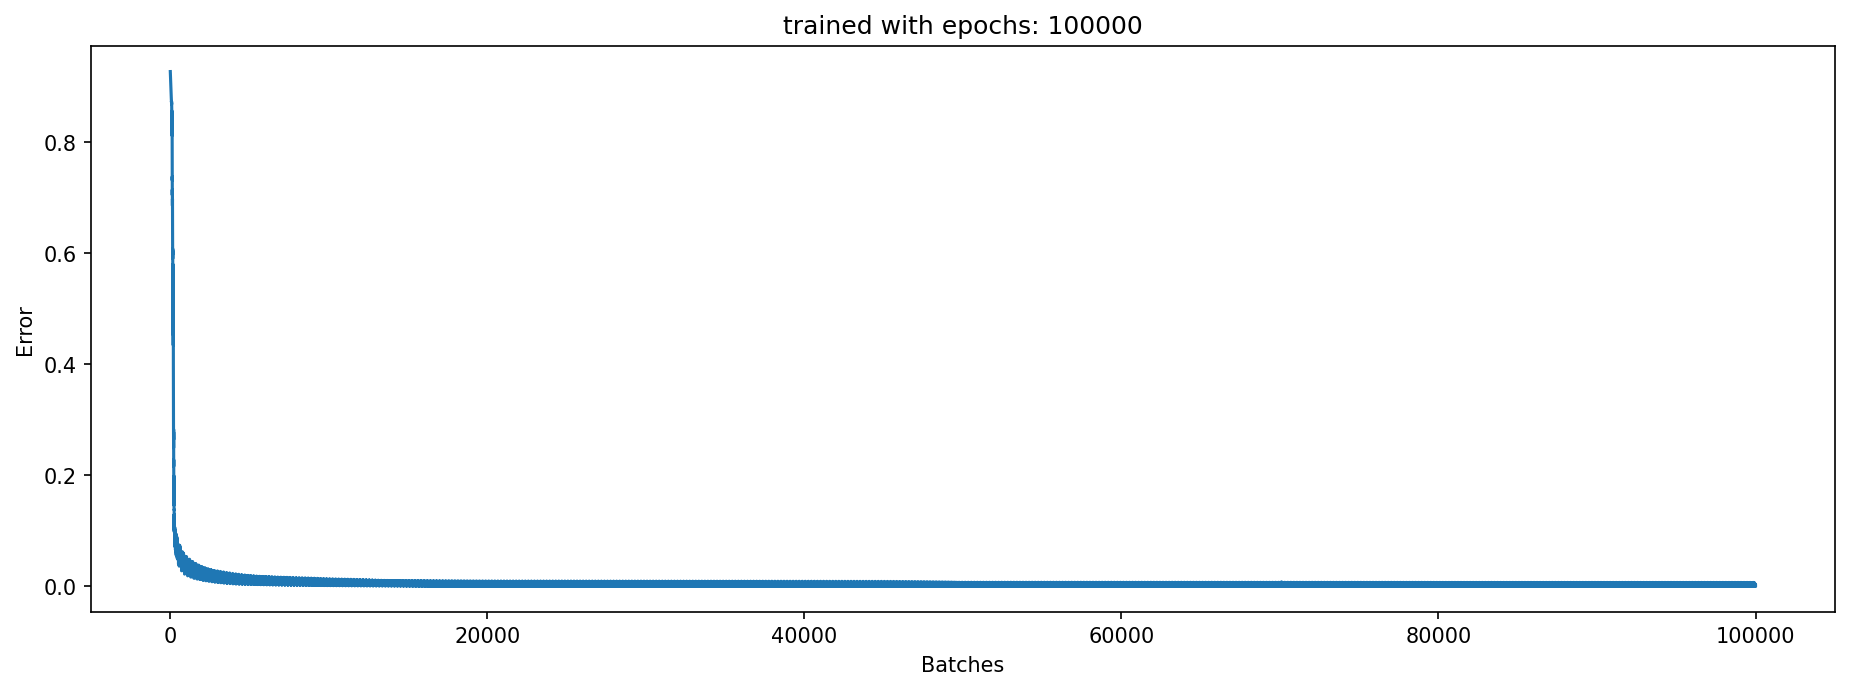

train 192000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.0020608174511465515
test 4000 batch_size 1000 correct 989.0 of 1000 Ratio 0.989 Error 0.01950864256808672
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6566784770753793
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.895                 0.492                0.776                 0.815
   2      1             0.952                 0.574                0.754                 0.879
   3      1             0.950                 0.521                0.667                 0.870
   4      1             0.960                 0.535                0.730                 0.878
   5      1             0.856                 0.621                0.677                 0.818
   6      1             0.961                 0.708                0.839                 0.905
 

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


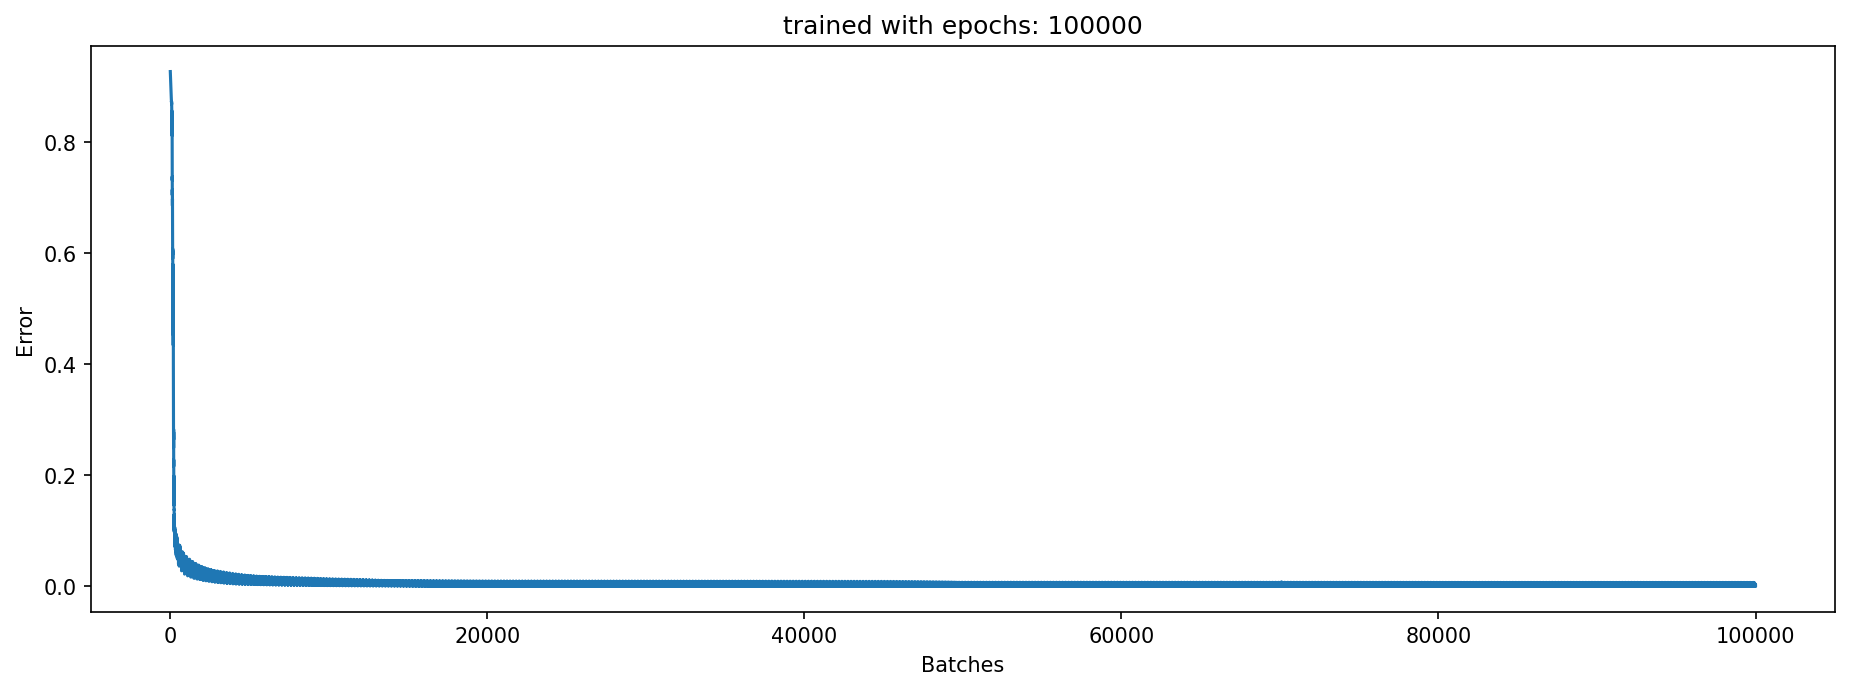

train 4000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.0011126788119728693
test 4000 batch_size 1000 correct 989.0 of 1000 Ratio 0.989 Error 0.01950864256808672
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6566784770753793
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.485                 0.597                0.706                 0.496
   2      1             0.296                 0.669                0.716                 0.357
   3      1             0.288                 0.310                0.670                 0.289
   4      1             0.335                 0.677                0.727                 0.399
   5      1             0.387                 0.683                0.811                 0.443
   6      1             0.382                 0.720                0.806                 0.438
   

In [1]:
<div class="burk">
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [1, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py </div><i class="fa fa-lightbulb-o "></i>

labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!


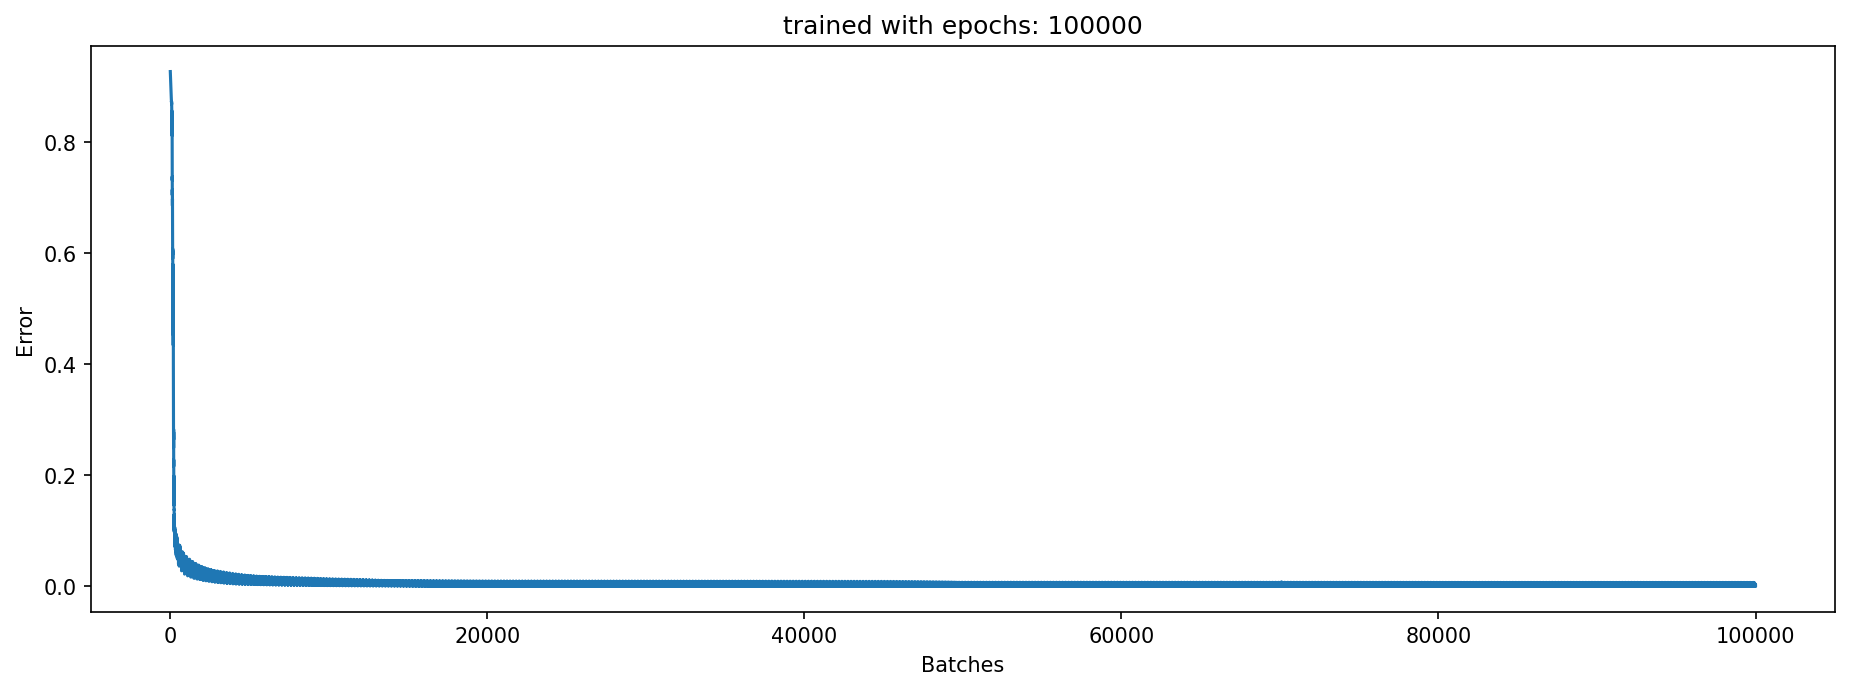

train 4000 batch_size 1000 correct 999.0 of 1000 Ratio 0.999 Error 0.0011126788119728693
test 4000 batch_size 1000 correct 989.0 of 1000 Ratio 0.989 Error 0.01950864256808672
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.6566784770753793
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.569                 0.508                0.517                 0.558
   2      1             0.672                 0.642                0.659                 0.661
   3      1             0.565                 0.505                0.517                 0.557
   4      1             0.649                 0.501                0.529                 0.626
   5      1             0.564                 0.642                0.661                 0.584
   6      1             0.684                 0.724                0.733                 0.696
   

In [1]:
<div class="girk">
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 1
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = True
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py </div><i class="fa fa-lightbulb-o "></i>

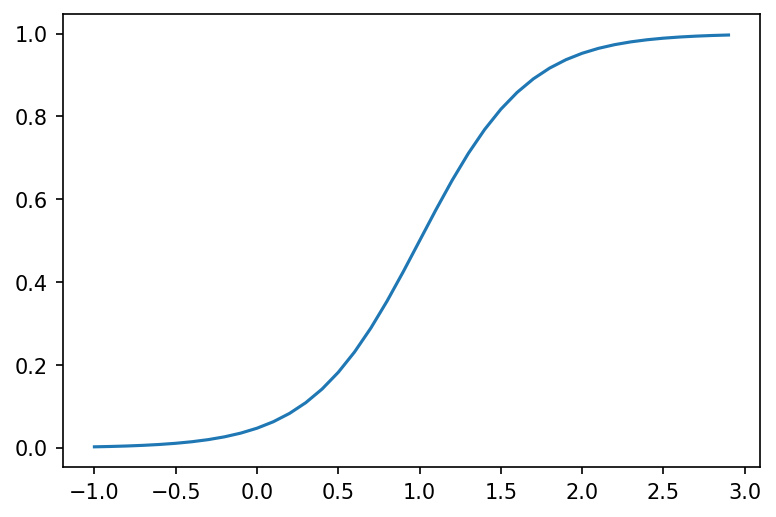

In [2]:
x = []
y = []
for xx in np.arange(-1,3,0.1):
    x.append(xx)
    y.append(sigmoid(xx))
pyplot.plot(x,y)
pyplot.show()

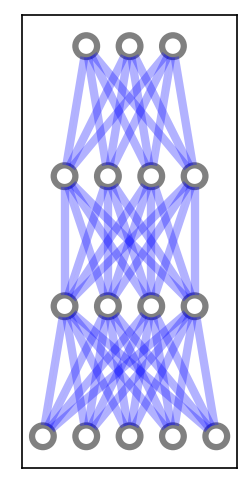

In [3]:
hidden_size = 4
inputs= np.array([[0,0,0,0,0]])
num_outputs = 3
outputs= np.array([[0,0,0]])
NN2 = setup_net()
NN2.set_input(inputs[0],outputs[0])
NN2.forward()
NN2.draw()

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]


  0%|          | 0/100000 [00:00<?, ?it/s]

start 15:55:56


Err  0.007: 100%|██████████| 100000/100000 [1:17:58<00:00, 21.37it/s]


end 17:13:55


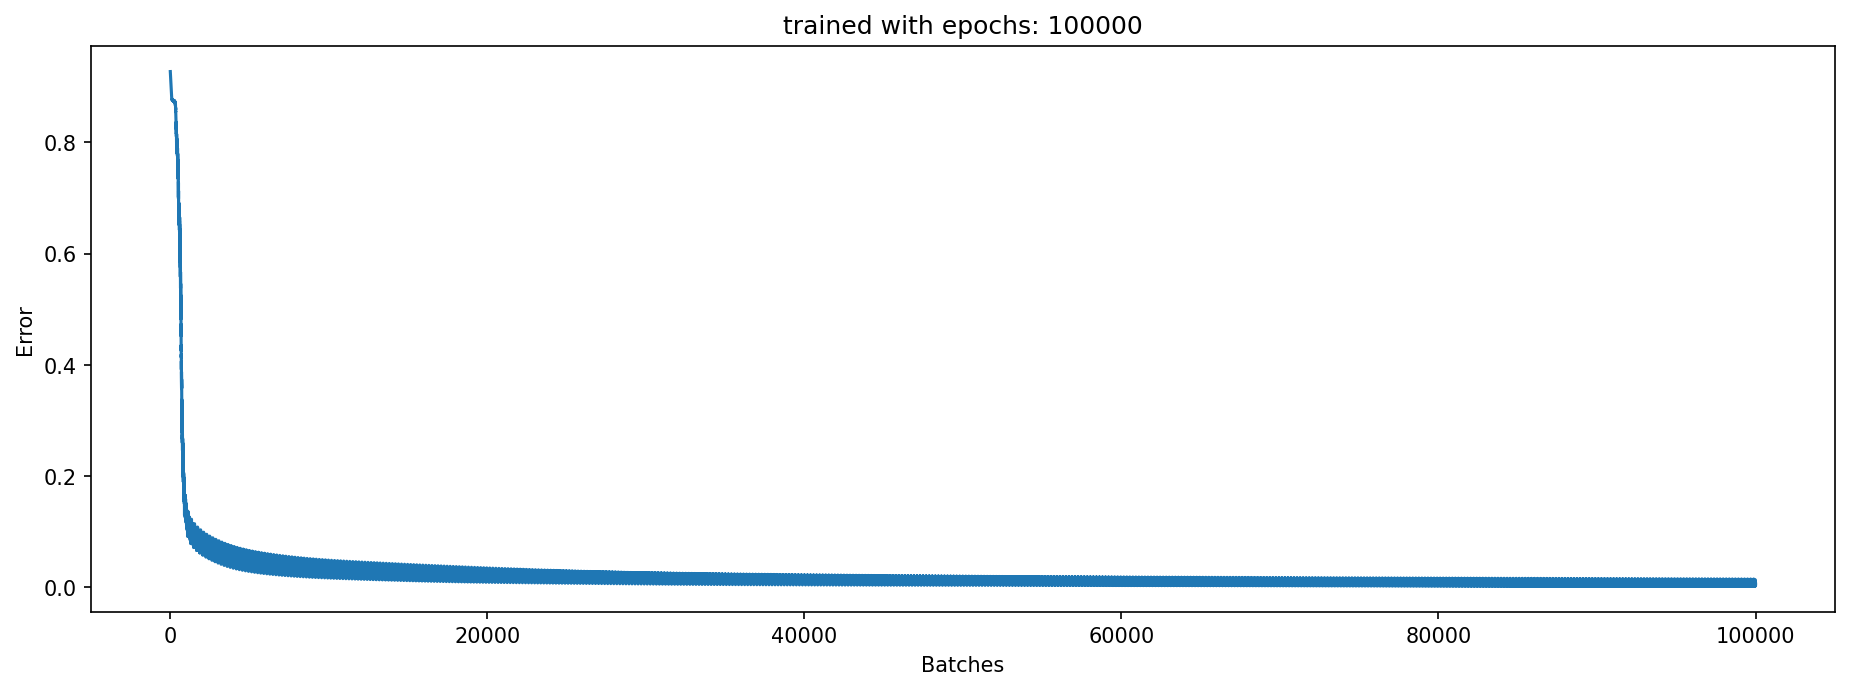

train 192000 batch_size 1000 correct 996.0 of 1000 Ratio 0.996 Error 0.008494603222037725
test 4000 batch_size 1000 correct 989.0 of 1000 Ratio 0.989 Error 0.021232006355433916
Testing if new lables were not learned !!!!!!!!!
new   4000 batch_size 1000 correct 0.0 of 1000 Ratio 0.0 Error 1.5956471595383732
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.896                 0.409                0.645                 0.809
   2      1             0.754                 0.573                0.699                 0.722
   3      1             0.926                 0.484                0.667                 0.841
   4      1             0.855                 0.637                0.832                 0.816
   5      1             0.836                 0.730                0.821                 0.813
   6      1             0.890                 0.574                0.688                 0.830
 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
#import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 #2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = 100000
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0.01 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.01, 1] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 

# Data for discussion / outlook

# Demonstration using few shot procedure for pre-training
5000 shots used for pre-training (for 8 of the 10 labels), reaching about 85% accuracy.

The few shot learning is done with the same network, reaching 75% after 10 shots, and more than 80% after 100 shots.

The learning rate of the first layer was reduced by a factor of 0.25, the one of the second layer by a factor of 0.5


Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  54912 dropped 0 real parameters 54912 drop definition []
loaded mnist Train dataset  with 10 labels [0, 1, 9, 3, 4, 5, 6, 7]


  0%|          | 0/5000 [00:00<?, ?it/s]

loaded mnist Test dataset  with 10 labels [0, 1, 9, 3, 4, 5, 6, 7]


Err 143.229 Acc  0.921: 100%|██████████| 5000/5000 [01:40<00:00, 49.71it/s]


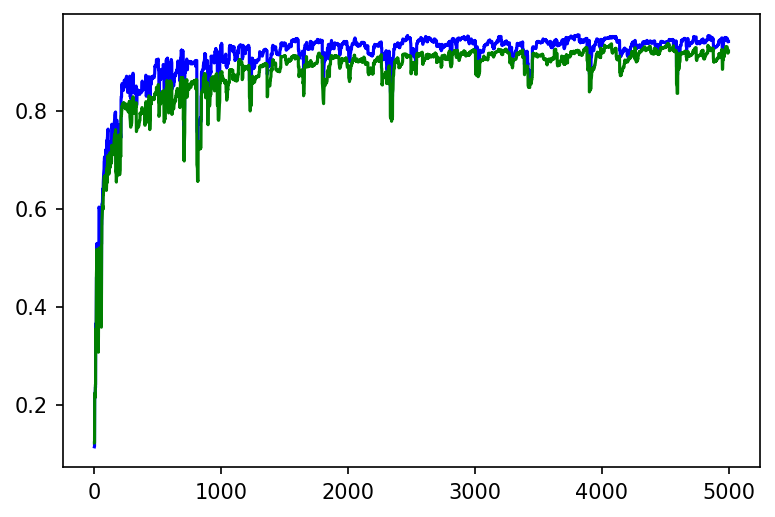

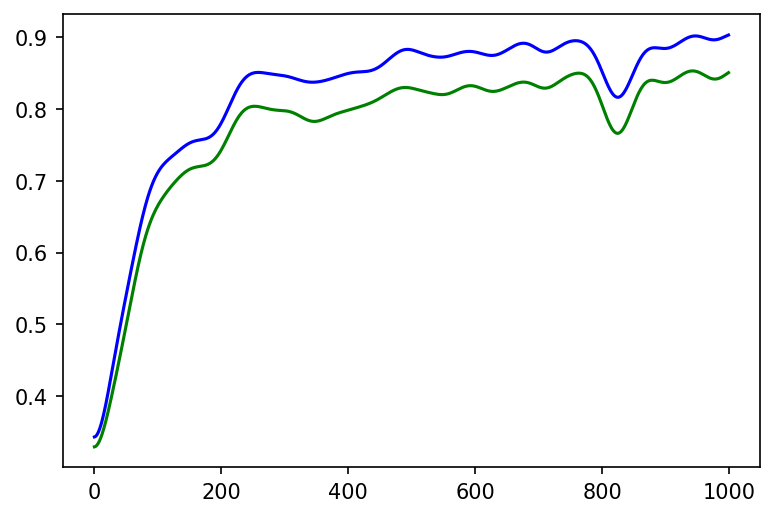

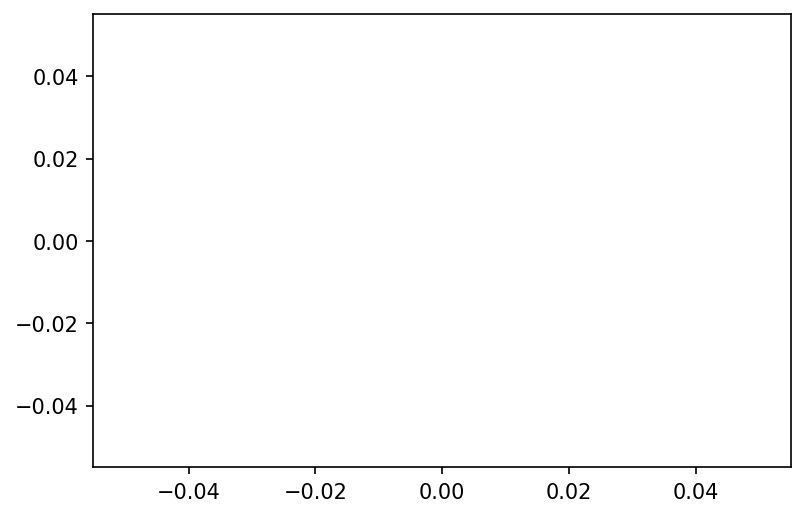

new   192000 batch_size 1000 correct 941.0 of 1000 Ratio 0.941 Error 0.11476924411094826
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.819                 0.268                0.661                 0.717
   2      1             0.705                 0.546                0.667                 0.667
   3      1             0.808                 0.381                0.617                 0.734
   4      1             0.799                 0.534                0.834                 0.752
   5      1             0.798                 0.573                0.852                 0.757
   6      1             0.802                 0.571                0.850                 0.760
   7      1             0.803                 0.566                0.849                 0.759
   8      1             0.801                 0.537                0.744                 0.747
   9      1             0.803 

  86      1             0.831                 0.861                0.973                 0.830
  87      1             0.813                 0.834                0.956                 0.810
  88      1             0.810                 0.835                0.954                 0.807
  89      1             0.816                 0.837                0.957                 0.813
  90      1             0.817                 0.835                0.959                 0.815
  91      1             0.816                 0.843                0.961                 0.816
  92      1             0.828                 0.850                0.967                 0.828
  93      1             0.832                 0.848                0.969                 0.830
  94      1             0.845                 0.855                0.960                 0.833
  95      1             0.854                 0.849                0.961                 0.843
  96      1             0.856                 0.84

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 64
two_hidden_layers = 1 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.01
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.1 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 2000
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 5000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.25, 0.5] # [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
inputs = None
outputs = None
bbs = None
verbose = 1
(inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2])
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
verbose = 0
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 1:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 1:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 1:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 1:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    err = np.sum(NN2.error**2)
    ttt.set_description("Err %6.3f Acc %6.3f" % (err, acc_test), refresh=False)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', err / len(NN2.error))
    if verbose > 0:
        print("%4d      %6d        %7.3f               %7.3f" % (i_shot + 1, epoch, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot[:1000],y1s[:1000],'b')
pyplot.plot(shot[:1000],y2s[:1000],'g')
pyplot.show()

y1s = gaussian_filter1d(y1, sigma=200)
y2s = gaussian_filter1d(y2, sigma=200)
pyplot.plot(shot[10000:],y1s[10000:],'b')
pyplot.plot(shot[10000:],y2s[10000:],'g')
pyplot.show()


try_mnist_few_shot = 100


NN2.set_input(inputs, outputs, batch_size=1000)
NN2.forward()
if num_outputs == 1:
    print('new  ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
else:
    print('new  ', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

# now try a few shot learning for some steps
# load with labels [8,9] and train every to a measure
#
# criteria label correct: (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0] true
# distance to second largest label
# biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
# ratio = biggest_two[-1] / [-2] > threshold

# max_iter is the maximal number of try's to optimize one data point in few_shot
pos_1 = 0
pos_2 = 0
try:
    print('few shot accuracy results')
    print('shot     try       old labels            new labels  new labels (forced)              over all')
    for i_shot in range(try_mnist_few_shot): # some shots
        if change_first_layers_slow_learning is not None:
            for l in range(len(change_first_layers_slow_learning)):
                before = NN2.layers[l].slow_learning
                NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
                if verbose > 0:
                    print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
        before = lr
        lr = lr_few_shot
        if verbose > 0:
            print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
        (inputs, outputs, bbs) = run_load_mnist(use_test = False)
        few1 = all_labels[-2]
        few2 = all_labels[-1]
        ok1 = False
        while not ok1:
            while outputs[pos_1].argmax() != few1:
                pos_1 += 1
            inp_1 = inputs[pos_1:pos_1+few_shot_more_at_once]
            outp_1 = outputs[pos_1:pos_1+few_shot_more_at_once]
            pos_1 += few_shot_more_at_once # prepare the next shot
            ok1 = True
            if check_wrong:
                for ii in range(1, few_shot_more_at_once):
                    if outp_1[ii].argmax() == few2:
                        ok1 = False
        ok2 = False
        while not ok2:
            while outputs[pos_2].argmax() != few2:
                pos_2 += 1
            inp_2 = inputs[pos_2:pos_2+few_shot_more_at_once]
            outp_2 = outputs[pos_2:pos_2+few_shot_more_at_once]
            pos_2 += few_shot_more_at_once
            ok2 = True
            if check_wrong:
                for ii in range(1, few_shot_more_at_once):
                    if outp_2[ii].argmax() == few1:
                        ok1 = False
        for m in range(use_every_shot_n_times):
            for (inp,outp) in [(inp_1,outp_1), (inp_2,outp_2)]:
                if verbose > 0:
                    print('start training', outp)
                epoch = 0
                NN2.set_input(inp, outp)
                while epoch < few_shot_max_try:
                    NN2.forward()
                    NN2.backward()
                    # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
                    if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0]:
                        biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
                        if do_pm:
                            ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
                        else:
                            ratio = biggest_two[-1] / biggest_two[-2]
                        if verbose > 0:
                            print(biggest_two, ratio)
                        if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                            break
            if verbose > 0:
                print('Results after few shot', i_shot + 1, 'used the ', m + 1, '. time')
                (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
            (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
            NN2.set_input(inputs, outputs, batch_size=1000)
            NN2.forward()
            acc_only_old_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
            (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
            NN2.set_input(inputs, outputs, batch_size=1000)
            NN2.forward()
            acc_only_new_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

            # here only the few_shot trained lables are considdered
            res_values = NN2.layers[-1].values
            mask = [0] * len(all_labels)
            for l in all_labels[-2:]:
                mask[l] = 1
            mask = np_array([mask])
            res_values = res_values * mask
            # deb = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum())
            acc_only_new_labels_forced = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('using only the few shot trained labels for possible output of neural net')
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(res_values.argmax(axis = 1) == few1), 'few2:', np.sum(res_values.argmax(axis = 1) == few2), 'correct', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))



            (inputs, outputs, bbs) = run_load_mnist(use_test = True, only_load_num=few_shot_fast_load_num)
            NN2.set_input(inputs, outputs, batch_size=1000)
            NN2.forward()
            acc_only_overall_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
            print("%4d    %3d           %7.3f               %7.3f              %7.3f               %7.3f" % (i_shot + 1, m + 1, acc_only_old_labels, acc_only_new_labels, acc_only_new_labels_forced, acc_only_overall_labels))
except KeyboardInterrupt:
    print('Interrupted')


Showing, that hidden_size 128 gives roughly the same result (not used in the paper at the moment)

Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!
labels (last two are used for few_shot) [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
Network parameters:  118016 dropped 0 real parameters 118016 drop definition []
loaded mnist Train dataset  with 10 labels [0, 1, 9, 3, 4, 5, 6, 7]


  0%|          | 0/5000 [00:00<?, ?it/s]

loaded mnist Test dataset  with 10 labels [0, 1, 9, 3, 4, 5, 6, 7]


Err 141.538 Acc  0.923: 100%|██████████| 5000/5000 [02:26<00:00, 34.10it/s]


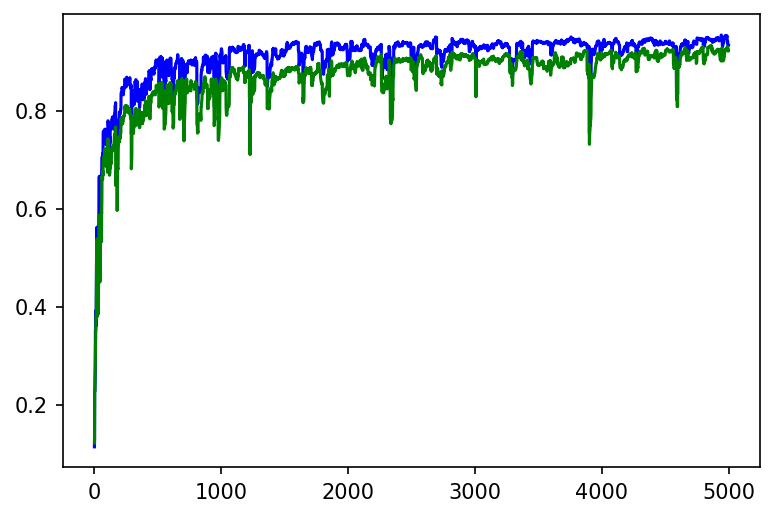

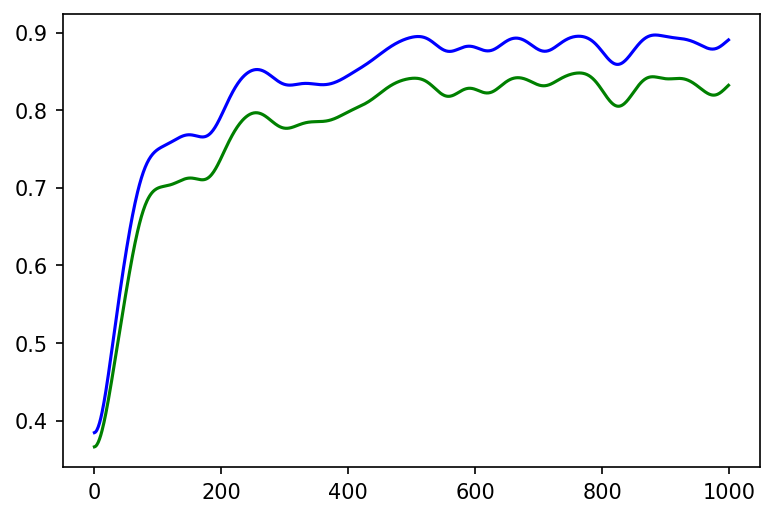

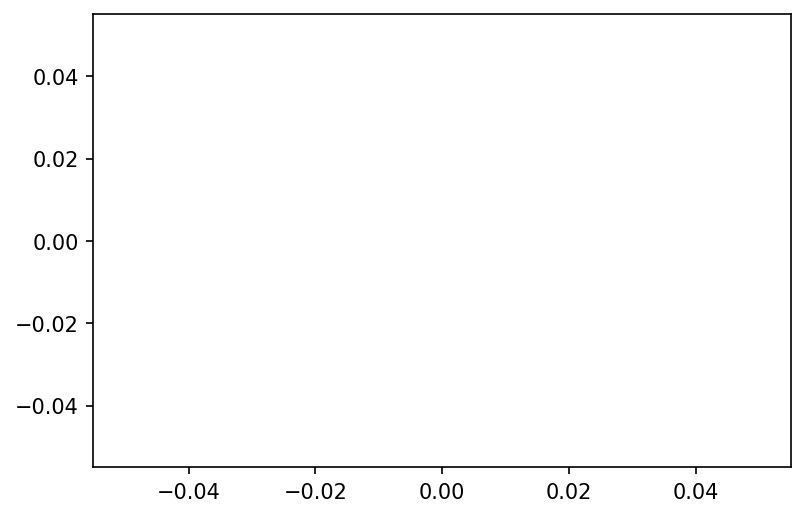

new   192000 batch_size 1000 correct 933.0 of 1000 Ratio 0.933 Error 0.11759154637022251
few shot accuracy results
shot     try       old labels            new labels  new labels (forced)              over all
   1      1             0.838                 0.367                0.656                 0.750
   2      1             0.730                 0.478                0.541                 0.673
   3      1             0.842                 0.486                0.740                 0.780
   4      1             0.777                 0.560                0.731                 0.726
   5      1             0.783                 0.608                0.788                 0.745
   6      1             0.805                 0.592                0.790                 0.762
   7      1             0.816                 0.585                0.805                 0.768
   8      1             0.816                 0.624                0.790                 0.776
   9      1             0.818 

  86      1             0.823                 0.812                0.946                 0.816
  87      1             0.799                 0.769                0.906                 0.791
  88      1             0.793                 0.775                0.907                 0.787
  89      1             0.803                 0.784                0.917                 0.795
  90      1             0.813                 0.779                0.922                 0.804
  91      1             0.811                 0.791                0.929                 0.804
  92      1             0.831                 0.807                0.950                 0.819
  93      1             0.833                 0.807                0.955                 0.821
  94      1             0.831                 0.843                0.949                 0.821
  95      1             0.838                 0.841                0.952                 0.826
  96      1             0.840                 0.84

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
based on: https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24
    and https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/29889993
    and https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6
    and https://www.python-course.eu/neural_network_mnist.php
Created on Sun Jul 19 15:45:02 2020

@author: detlef

INSTALLATION:
use it within anaconda and install cupy if cuda availible
you will need https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv (mnist in csv) in the data/mnist subdirectory
emnist not in anaconda at the moment, use pip install emnist

on Google Colab (turn on GPU!!)
!curl https://colab.chainer.org/install | sh -
!pip install emnist

REMARKS:
    
loss function used = 1/2 SUM(error**2) // making the derivative error
"""

#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 128
two_hidden_layers = 1 # additional hidden layers, totaly two_hidden_layers + 1
use_bias = False

lr = 2
lr_few_shot = 0.01
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.5
init_rand_ampl0 = 0.1 # 2 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.2 # for early tests (no mnist)
few_shot_max_try = 2000
few_shot_threshold_ratio = 1.1 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 5
check_wrong = True

all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!
try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 16

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [1], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = True
load_mnist = True

do_batch_training = -1
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 1 # 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 10 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 5000
use_every_shot_n_times = 1 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.25, 0.5] # [0.04, 0.2] # [0, 0.1]


disable_progressbar = False

# uncomment to run in jupyter notebook
%run -i _code_.py 



def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    for _ in range(two_hidden_layers):
        if verbose > 0:
            print('additional hidden layer')
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2

NN2 = setup_net()

pos_1 = 0
inputs = None
outputs = None
bbs = None
verbose = 1
(inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2])
(inputs_test, outputs_test, bbs_test) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
verbose = 0
shot=[]
y1=[]
y2=[]
ttt = tqdm(range(try_mnist_few_shot), mininterval = 10, disable=disable_progressbar)
for i_shot in ttt: # some shots
    if change_first_layers_slow_learning is not None:
        for l in range(len(change_first_layers_slow_learning)):
            before = NN2.layers[l].slow_learning
            NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
            if verbose > 1:
                print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
    before = lr
    lr = lr_few_shot
    if verbose > 1:
        print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
    begin = pos_1 - few_shot_more_at_once
    if begin < 0:
        begin = 0
    inp = inputs[begin:pos_1+1]
    outp = outputs[begin:pos_1+1]
    pos_1 += 1 # few_shot_more_at_once
    if verbose > 1:
        print('start training', outp)
    epoch = 0
    NN2.set_input(inp, outp)
    while epoch < few_shot_max_try:
        epoch += 1
        NN2.forward()
        NN2.backward()
        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[-1]: # -1 is the last
            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
            if do_pm:
                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
            else:
                ratio = biggest_two[-1] / biggest_two[-2]
            if verbose > 1:
                print(biggest_two, ratio)
            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                break
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    acc_train = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size,  'acc_train', acc_train, 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    NN2.set_input(inputs_test, outputs_test, batch_size=1000)
    NN2.forward()
    acc_test = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
    err = np.sum(NN2.error**2)
    ttt.set_description("Err %6.3f Acc %6.3f" % (err, acc_test), refresh=False)
    if verbose > 1:
        print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'acc_test', acc_test, 'Error', err / len(NN2.error))
    if verbose > 0:
        print("%4d      %6d        %7.3f               %7.3f" % (i_shot + 1, epoch, acc_train, acc_test))
    shot.append(i_shot)
    y1.append(acc_train)
    y2.append(acc_test)
pyplot.plot(shot,y1,'b')
pyplot.plot(shot,y2,'g')
pyplot.show()

from scipy.ndimage.filters import gaussian_filter1d
y1s = gaussian_filter1d(y1, sigma=20)
y2s = gaussian_filter1d(y2, sigma=20)
pyplot.plot(shot[:1000],y1s[:1000],'b')
pyplot.plot(shot[:1000],y2s[:1000],'g')
pyplot.show()

y1s = gaussian_filter1d(y1, sigma=200)
y2s = gaussian_filter1d(y2, sigma=200)
pyplot.plot(shot[10000:],y1s[10000:],'b')
pyplot.plot(shot[10000:],y2s[10000:],'g')
pyplot.show()


try_mnist_few_shot = 100


NN2.set_input(inputs, outputs, batch_size=1000)
NN2.forward()
if num_outputs == 1:
    print('new  ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
else:
    print('new  ', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

# now try a few shot learning for some steps
# load with labels [8,9] and train every to a measure
#
# criteria label correct: (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0] true
# distance to second largest label
# biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
# ratio = biggest_two[-1] / [-2] > threshold

# max_iter is the maximal number of try's to optimize one data point in few_shot
pos_1 = 0
pos_2 = 0
try:
    print('few shot accuracy results')
    print('shot     try       old labels            new labels  new labels (forced)              over all')
    for i_shot in range(try_mnist_few_shot): # some shots
        if change_first_layers_slow_learning is not None:
            for l in range(len(change_first_layers_slow_learning)):
                before = NN2.layers[l].slow_learning
                NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
                if verbose > 0:
                    print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
        before = lr
        lr = lr_few_shot
        if verbose > 0:
            print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
        (inputs, outputs, bbs) = run_load_mnist(use_test = False)
        few1 = all_labels[-2]
        few2 = all_labels[-1]
        ok1 = False
        while not ok1:
            while outputs[pos_1].argmax() != few1:
                pos_1 += 1
            inp_1 = inputs[pos_1:pos_1+few_shot_more_at_once]
            outp_1 = outputs[pos_1:pos_1+few_shot_more_at_once]
            pos_1 += few_shot_more_at_once # prepare the next shot
            ok1 = True
            if check_wrong:
                for ii in range(1, few_shot_more_at_once):
                    if outp_1[ii].argmax() == few2:
                        ok1 = False
        ok2 = False
        while not ok2:
            while outputs[pos_2].argmax() != few2:
                pos_2 += 1
            inp_2 = inputs[pos_2:pos_2+few_shot_more_at_once]
            outp_2 = outputs[pos_2:pos_2+few_shot_more_at_once]
            pos_2 += few_shot_more_at_once
            ok2 = True
            if check_wrong:
                for ii in range(1, few_shot_more_at_once):
                    if outp_2[ii].argmax() == few1:
                        ok1 = False
        for m in range(use_every_shot_n_times):
            for (inp,outp) in [(inp_1,outp_1), (inp_2,outp_2)]:
                if verbose > 0:
                    print('start training', outp)
                epoch = 0
                NN2.set_input(inp, outp)
                while epoch < few_shot_max_try:
                    NN2.forward()
                    NN2.backward()
                    # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
                    if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0]:
                        biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
                        if do_pm:
                            ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
                        else:
                            ratio = biggest_two[-1] / biggest_two[-2]
                        if verbose > 0:
                            print(biggest_two, ratio)
                        if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                            break
            if verbose > 0:
                print('Results after few shot', i_shot + 1, 'used the ', m + 1, '. time')
                (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
            (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
            NN2.set_input(inputs, outputs, batch_size=1000)
            NN2.forward()
            acc_only_old_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
            (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
            NN2.set_input(inputs, outputs, batch_size=1000)
            NN2.forward()
            acc_only_new_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

            # here only the few_shot trained lables are considdered
            res_values = NN2.layers[-1].values
            mask = [0] * len(all_labels)
            for l in all_labels[-2:]:
                mask[l] = 1
            mask = np_array([mask])
            res_values = res_values * mask
            # deb = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum())
            acc_only_new_labels_forced = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('using only the few shot trained labels for possible output of neural net')
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(res_values.argmax(axis = 1) == few1), 'few2:', np.sum(res_values.argmax(axis = 1) == few2), 'correct', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))



            (inputs, outputs, bbs) = run_load_mnist(use_test = True, only_load_num=few_shot_fast_load_num)
            NN2.set_input(inputs, outputs, batch_size=1000)
            NN2.forward()
            acc_only_overall_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
            if verbose > 0:
                print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
            print("%4d    %3d           %7.3f               %7.3f              %7.3f               %7.3f" % (i_shot + 1, m + 1, acc_only_old_labels, acc_only_new_labels, acc_only_new_labels_forced, acc_only_overall_labels))
except KeyboardInterrupt:
    print('Interrupted')
